In [1]:
### Import all necessity functions for Machine Learning #####
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics._plot.confusion_matrix import confusion_matrix
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

#####Import the dataset

In [2]:
df = pd.read_csv('/content/diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


#####Split the dataset into train and test

In [3]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

print("The Shape of X_train # {} ".format(X_train.shape),'\n')
print("The Shape of X_test  # {} ".format(X_test.shape),'\n')
print("The Shape of y_train # {} ".format(y_train.shape),'\n')
print("The Shape of y_test  # {} ".format(y_test.shape))

The Shape of X_train # (576, 8)  

The Shape of X_test  # (192, 8)  

The Shape of y_train # (576,)  

The Shape of y_test  # (192,) 


#####Import the DataLoader to initialize the batch_size

In [4]:
import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

In [5]:
#### Convert the X_train and X_test into tensor Float to prevent error
X_train = torch.tensor(data = X_train, dtype = torch.float32)
X_test  = torch.tensor(data = X_test, dtype = torch.float32)

#### Convert the y_train and y_test into tensor Float to prevent error
y_train = torch.tensor(data = y_train, dtype = torch.float32)
y_test  = torch.tensor(data = y_test, dtype = torch.float32)

### Initialize the batch_size
BATCH_SIZE = 32
### Initialize the train loader
train_loader = DataLoader(dataset = list(zip(X_train, y_train)), batch_size = BATCH_SIZE, shuffle = True)
### Initialize the test loader
test_loader  = DataLoader(dataset = list(zip(X_test, y_test)), batch_size = BATCH_SIZE, shuffle = True)

In [6]:
train_data, train_label = next(iter(train_loader))
test_data, test_label   = next(iter(test_loader))

print("train_loader shape with batch_size # {} ".format(train_data.shape),'\n')
print("test_loader shape with batch_size  # {} ".format(test_data.shape),'\n')
print("train_label shape with batch_size  # {} ".format(train_label.shape),'\n')
print("test_label shape with batch_size   # {} ".format(test_label.shape))

train_loader shape with batch_size # torch.Size([32, 8])  

test_loader shape with batch_size  # torch.Size([32, 8])  

train_label shape with batch_size  # torch.Size([32])  

test_label shape with batch_size   # torch.Size([32]) 


#####Model building

In [7]:
from pandas._libs import parsers
"""
Define class named DiabetesClassifier that will take TWO parameters
1. input_dimension
2. output_dimension
"""
class DiabetesClassifier(nn.Module):
  """Define a constructor"""
  def __init__(self, input_dimension = None, output_dimension = None):
    """Call the super() class of parent class that is nothing but inherit all the imperative functions"""
    super().__init__()
    """
    Create First Hidden Layer & activation function
    1. input_features  = input_dimension
    2. output_features = 512
    3. Activation (ReLU)
    """
    self.hiddenLayer1 = nn.Linear(in_features = input_dimension, out_features = 512)
    self.activation1  = nn.ReLU()

    """
    Create the Second Hidden Layer & activation function
    1. input_features  = 512
    2. output_features = 128
    3. Activation (ReLU)
    """
    self.hiddenLayer2 = nn.Linear(in_features = 512, out_features = 128)
    self.activation2  = nn.ReLU()

    """
    Create the output layer & activation function
    1. input_features  = 128
    2. output_features = output_dimension
    3. Activation (Sigmoid)
    """
    self.outputLayer = nn.Linear(in_features = 128, out_features = output_dimension)
    self.activation  = nn.Sigmoid()

  def forward(self, x):
    """For the First Hidden Layer"""
    x = self.activation1(self.hiddenLayer1(x))

    """For the Second Layer"""
    x = self.activation2(self.hiddenLayer2(x))

    """For the output Layer"""
    if self.activation is not None:
      x = self.activation(self.outputLayer(x))
    else:
      x = self.outputLayer(x)

    return x

In [8]:
### Call the DiabetesClassifer model
try:
  model = DiabetesClassifier(input_dimension = X_train.shape[1], output_dimension = len(df.iloc[:, -1].value_counts().index) - 1)
except Exception as e:
  print(e.with_traceback)
else:
  print(model.parameters)

<bound method Module.parameters of DiabetesClassifier(
  (hiddenLayer1): Linear(in_features=8, out_features=512, bias=True)
  (activation1): ReLU()
  (hiddenLayer2): Linear(in_features=512, out_features=128, bias=True)
  (activation2): ReLU()
  (outputLayer): Linear(in_features=128, out_features=1, bias=True)
  (activation): Sigmoid()
)>


In [9]:
#### Display the model
summary(model = model, input_size = X_train.shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 576, 512]           4,608
              ReLU-2             [-1, 576, 512]               0
            Linear-3             [-1, 576, 128]          65,664
              ReLU-4             [-1, 576, 128]               0
            Linear-5               [-1, 576, 1]             129
           Sigmoid-6               [-1, 576, 1]               0
Total params: 70,401
Trainable params: 70,401
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 5.63
Params size (MB): 0.27
Estimated Total Size (MB): 5.92
----------------------------------------------------------------


In [10]:
#### Show what is stored in the model.parameters()
next(iter(model.parameters()))

Parameter containing:
tensor([[ 0.0439,  0.1998, -0.0324,  ..., -0.2298, -0.3078,  0.3016],
        [ 0.0424,  0.1633, -0.0756,  ...,  0.1836,  0.2065,  0.0173],
        [-0.2706,  0.3240, -0.0787,  ..., -0.2405, -0.1675,  0.1050],
        ...,
        [ 0.3100,  0.2995, -0.2768,  ..., -0.0787,  0.1962, -0.1122],
        [ 0.2419,  0.2781, -0.2644,  ..., -0.3431, -0.1498,  0.2856],
        [ 0.0505,  0.3337,  0.1420,  ...,  0.1966,  0.3304, -0.1190]],
       requires_grad=True)

#####Initialize the loss & activation

In [11]:
LEARNING_RATE = 0.001
loss_function = nn.BCELoss()
optimizer = optim.Adam(params = model.parameters(), lr = LEARNING_RATE)

##### Training the model without Early Stopping

In [12]:
from sklearn.metrics import accuracy_score
"""Initialize some of the basic varibales that would be needed in further"""
EPOCHS = 100
TRAIN_LOSS = []
VAL_LOSS = []
TRAIN_ACCURACY = []
VAL_ACCURACY = []

"""
Start the training &
Run a loop with EPOCHS
"""
model.train()
for epoch in range(EPOCHS):
  ########################
  #     For Training     #
  ########################
  """
  Extract the data(X_batch), label(y_batch) from the `train_loader`: (To do this run a loop)
  and pass the X_batch data to the model for the prediction purpose
  """
  for (X_batch, y_batch) in train_loader:
    ### Do the prediction
    train_prediction = model(X_batch)
    """
    Compute the loss function and pass this prediction result and y_batch
    """
    train_loss = loss_function(train_prediction.flatten(), y_batch)
    """
    1. Initialize the Gradient of Optimizer
    2. Do the backward propagation of tarin loss
    3. Do the step of optimizer
    """
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

  """
  Append the train loss into TRAIN_LOSS and
  train accuracy into TRAIN_ACCURACY
  """
  with torch.no_grad():
    TRAIN_LOSS.append(train_loss.item())
    """
    Though using Sigmoid(): To convert the binary class classification this formula need to be executed.
    value > 0.5 means 1
    value < 0.5 means 0
    """
    train_predicted = np.where(train_prediction.flatten() > 0.5, 1, 0)
    #### Store the accuracy
    TRAIN_ACCURACY.append(accuracy_score(train_predicted, y_batch))

  ########################
  #      For Testing     #
  ########################

  with torch.no_grad():
    model.eval()
    for (val_batch, val_label) in test_loader:
      """
      Pass this valiadtion batch data to the model and do the prediction
      """
      val_prediction = model(val_batch)
      val_loss = loss_function(val_prediction.flatten(), y_batch)

    """
    Append the val loss into VAL_LOSS and
    val accuracy into VAL_ACCURACY
    """
    VAL_LOSS.append(train_loss)
    """
    Though using Sigmoid(): To convert the binary class classification this formula need to be executed.
    value > 0.5 means 1
    value < 0.5 means 0
    """
    val_predicted = torch.where(val_prediction.flatten() > 0.5, 1, 0)
    VAL_ACCURACY.append(accuracy_score(val_predicted, val_label))

    ######################
    #      Display       #
    ######################
    print("Epoch {}/{} ".format(epoch + 1, EPOCHS))
    print("{}/{} [=============================] loss: {} - accuracy: {} - val_loss: {} - val_accuracy: {}".format(
                                                                    test_loader.batch_size,\
                                                                    test_loader.batch_size,\
                                                                    np.array(train_loss.item()).mean(),\
                                                                    accuracy_score(train_predicted, y_batch),\
                                                                    np.array(val_loss).mean(),\
                                                                    accuracy_score(val_predicted, val_label)))

Epoch 1/100 
32/32 [=============================] loss: 2.348452091217041 - accuracy: 0.34375 - val_loss: 1.736914873123169 - val_accuracy: 0.625
Epoch 2/100 
32/32 [=============================] loss: 0.5629441142082214 - accuracy: 0.71875 - val_loss: 0.932195246219635 - val_accuracy: 0.78125
Epoch 3/100 
32/32 [=============================] loss: 0.48586225509643555 - accuracy: 0.75 - val_loss: 0.7791537046432495 - val_accuracy: 0.65625
Epoch 4/100 
32/32 [=============================] loss: 0.7338595390319824 - accuracy: 0.59375 - val_loss: 0.6863433122634888 - val_accuracy: 0.75
Epoch 5/100 
32/32 [=============================] loss: 0.7137531042098999 - accuracy: 0.59375 - val_loss: 0.9052715301513672 - val_accuracy: 0.5625
Epoch 6/100 
32/32 [=============================] loss: 0.6837322115898132 - accuracy: 0.625 - val_loss: 1.0159658193588257 - val_accuracy: 0.53125
Epoch 7/100 
32/32 [=============================] loss: 0.5329897403717041 - accuracy: 0.6875 - val_loss: 

##### Plot the loss and accuracy with respect to train & val

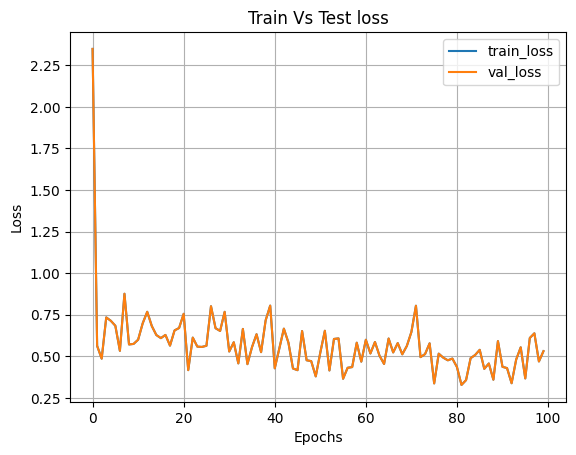

In [13]:
with torch.no_grad():
  plt.title("Train Vs Test loss")
  plt.plot(np.array(TRAIN_LOSS), label = 'train_loss')
  plt.plot(np.array(VAL_LOSS), label = 'val_loss')
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.grid(True)
  plt.legend()
  plt.show()

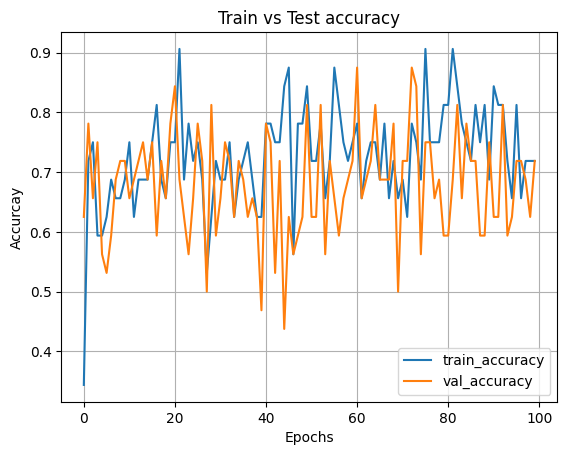

In [14]:
with torch.no_grad():
  plt.title("Train vs Test accuracy")
  plt.plot(np.array(TRAIN_ACCURACY), label = 'train_accuracy')
  plt.plot(np.array(VAL_ACCURACY), label = 'val_accuracy')
  plt.legend()
  plt.xlabel("Epochs")
  plt.ylabel("Accurcay")
  plt.grid(True)
  plt.show()

#Using Early Stopping !

In [16]:
from sklearn.metrics import accuracy_score
"""Initialize some of the basic varibales that would be needed in further"""
EPOCHS = 250
TRAIN_LOSS = []
VAL_LOSS = []
TRAIN_ACCURACY = []
VAL_ACCURACY = []
"""This variables is needed for Early Stopping"""
BEST_ACCURACY = -1
BEST_EPOCH = -1
PATIENCE = 30
STORE_BEST = {}

"""
Start the training &
Run a loop with EPOCHS
"""
model.train()
for epoch in range(EPOCHS):
  UPDATE = 0
  ########################
  #     For Training     #
  ########################
  """
  Extract the data(X_batch), label(y_batch) from the `train_loader`: (To do this run a loop)
  and pass the X_batch data to the model for the prediction purpose
  """
  for (X_batch, y_batch) in train_loader:
    ### Do the prediction
    train_prediction = model(X_batch)
    """
    Compute the loss function and pass this prediction result and y_batch
    """
    train_loss = loss_function(train_prediction.flatten(), y_batch)
    """
    1. Initialize the Gradient of Optimizer
    2. Do the backward propagation of tarin loss
    3. Do the step of optimizer
    """
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

  """
  Append the train loss into TRAIN_LOSS and
  train accuracy into TRAIN_ACCURACY
  """
  with torch.no_grad():
    TRAIN_LOSS.append(train_loss)
    """
    Though using Sigmoid(): To convert the binary class classification this formula need to be executed.
    value > 0.5 means 1
    value < 0.5 means 0
    """
    train_predicted = np.where(train_prediction.flatten() > 0.5, 1, 0)
    #### Store the accuracy
    TRAIN_ACCURACY.append(accuracy_score(train_predicted, y_batch))

  ########################
  #      For Testing     #
  ########################

  with torch.no_grad():
    model.eval()
    for (val_batch, val_label) in test_loader:
      """
      Pass this valiadtion batch data to the model and do the prediction
      """
      val_prediction = model(val_batch)
      val_loss = loss_function(val_prediction.flatten(), y_batch)

    """
    Append the val loss into VAL_LOSS and
    val accuracy into VAL_ACCURACY
    """
    VAL_LOSS.append(train_loss)
    """
    Though using Sigmoid(): To convert the binary class classification this formula need to be executed.
    value > 0.5 means 1
    value < 0.5 means 0
    """
    val_predicted = torch.where(val_prediction.flatten() > 0.5, 1, 0)
    VAL_ACCURACY.append(accuracy_score(val_predicted, val_label))

    #########################
    #    Early Stopping     #
    #########################

    """
    Early Stopping Concept is here
    """
    if (np.round(accuracy_score(val_predicted, val_label), 4) > BEST_ACCURACY):
      BEST_ACCURACY = np.round(accuracy_score(val_predicted, val_label), 4)
      BEST_EPOCH = epoch + 1
      STORE_BEST[BEST_EPOCH] = BEST_ACCURACY

    if abs((epoch + 1) - BEST_EPOCH) > PATIENCE:
      print("\n\nModel is terminated here !!!! The Epoch ## {} & accuracy ## {} ".format(BEST_EPOCH, BEST_ACCURACY))
      break

    ######################
    #      Display       #
    ######################
    print("Epoch {}/{} ".format(epoch + 1, EPOCHS))
    print("{}/{} [=============================] loss: {} - accuracy: {} - val_loss: {} - val_accuracy: {}".format(
                                                                    test_loader.batch_size,\
                                                                    test_loader.batch_size,\
                                                                    np.array(train_loss.item()).mean(),\
                                                                    accuracy_score(train_predicted, y_batch),\
                                                                    np.array(val_loss).mean(),\
                                                                    accuracy_score(val_predicted, val_label)))

Epoch 1/250 
32/32 [=============================] loss: 0.4478384256362915 - accuracy: 0.84375 - val_loss: 1.181699514389038 - val_accuracy: 0.78125
Epoch 2/250 
32/32 [=============================] loss: 0.48959964513778687 - accuracy: 0.78125 - val_loss: 0.8871104717254639 - val_accuracy: 0.625
Epoch 3/250 
32/32 [=============================] loss: 0.5299930572509766 - accuracy: 0.65625 - val_loss: 1.1787599325180054 - val_accuracy: 0.625
Epoch 4/250 
32/32 [=============================] loss: 0.526441216468811 - accuracy: 0.6875 - val_loss: 0.9079824686050415 - val_accuracy: 0.75
Epoch 5/250 
32/32 [=============================] loss: 0.395026296377182 - accuracy: 0.8125 - val_loss: 0.7295809984207153 - val_accuracy: 0.5
Epoch 6/250 
32/32 [=============================] loss: 0.3011649250984192 - accuracy: 0.875 - val_loss: 0.6356711983680725 - val_accuracy: 0.6875
Epoch 7/250 
32/32 [=============================] loss: 0.5787474513053894 - accuracy: 0.78125 - val_loss: 0.82

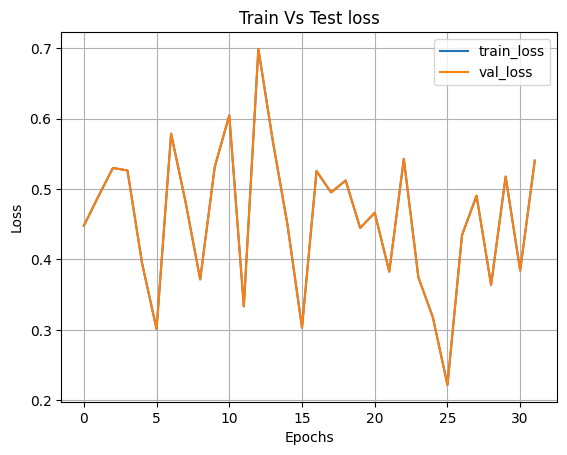

In [17]:
with torch.no_grad():
  plt.title("Train Vs Test loss")
  plt.plot(np.array(TRAIN_LOSS), label = 'train_loss')
  plt.plot(np.array(VAL_LOSS), label = 'val_loss')
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.grid(True)
  plt.legend()
  plt.show()

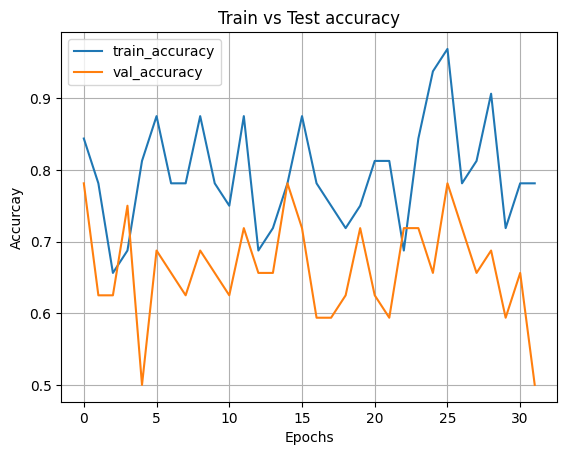

In [18]:
with torch.no_grad():
  plt.title("Train vs Test accuracy")
  plt.plot(np.array(TRAIN_ACCURACY), label = 'train_accuracy')
  plt.plot(np.array(VAL_ACCURACY), label = 'val_accuracy')
  plt.legend()
  plt.xlabel("Epochs")
  plt.ylabel("Accurcay")
  plt.grid(True)
  plt.show()